# Image Processing: Histogram of Oriented Gradients (HOG) with MNIST Dataset

In [149]:
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from sklearn.preprocessing import OneHotEncoder
from torchvision import transforms
from skimage.transform import resize
from skimage.feature import hog
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

In [150]:
def transform(input):
    features = hog(
        input,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2,2),
    )

    # convert numpy to tensor
    return torch.from_numpy(features).type(torch.FloatTensor)

# get training and test set
mnist_train = MNIST("./data/", download = True, transform = transform)
mnist_test = MNIST("./data/", train = False, download = True, transform = transform)

In [151]:
batch_size = 128
train_loader = DataLoader(mnist_train, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(mnist_test, batch_size = batch_size)

In [152]:
# classification with SVM loss
svm = nn.Linear(144, 10)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(svm.parameters(), lr = 0.01)

losses = []
num_epochs = 10
for it in range(num_epochs):
    for imgs, labels in train_loader:
        # forward pass
        output = svm(imgs)
        loss = criterion(output, labels)
        losses.append(loss.item())

        # backward pass
        loss.backward()

        # update
        optimizer.step()
        optimizer.zero_grad()

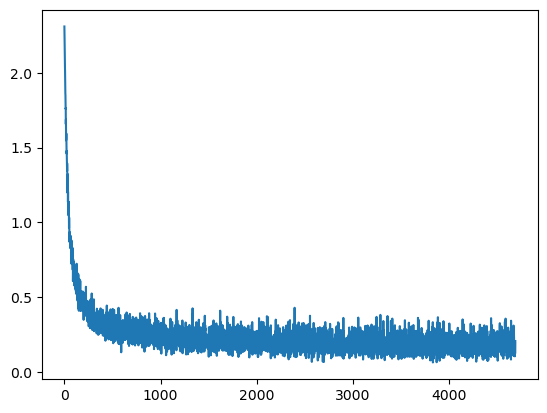

In [153]:
# let's look at the losses
plt.plot(losses)
plt.show()

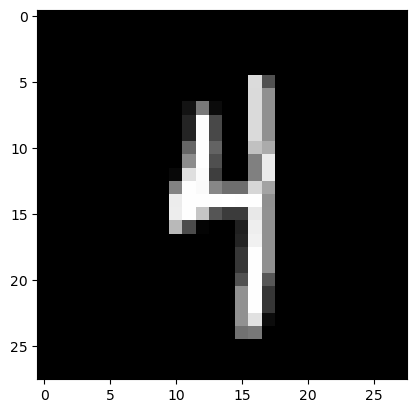

torch.Size([144])
4


In [154]:
# randomly select image from test set
sample = mnist_test.data[65]
plt.imshow(sample, cmap = 'gray')
plt.show()
sample = transform(sample)
print(sample.shape)

# predict sample
prediction = np.argmax(svm(sample).detach().numpy())
print(prediction)

In [155]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

Confusion matrix, without normalization
[[ 966    1    4    0    0    1    6    0    2    0]
 [   4 1111    7    0    7    0    3    2    1    0]
 [   4    3  994    9    5    0    1    9    4    3]
 [   2    0   22  949    1    6    0    2   13   15]
 [   8    8    8    2  919    0    9    4    8   16]
 [   9    2    2   20    0  826   11    2   17    3]
 [   9    1    0    0   11    8  921    0    7    1]
 [   0    3   29    6   15    1    0  932    7   35]
 [   9    1    6   14   12    4    4    6  898   20]
 [   9    2    2    6   13    4    1   19   19  934]]


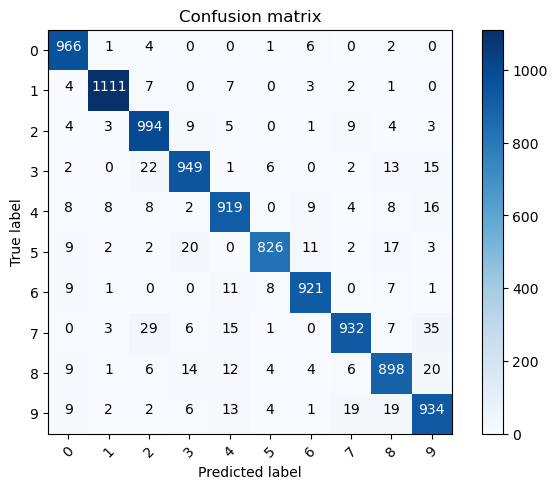

In [156]:
x_test = mnist_test.data.numpy()
y_test = mnist_test.targets.numpy()
p_test = np.array([])
for inputs, targets in test_loader:
  # Forward pass
  outputs = svm(inputs)
  _, predictions = torch.max(outputs, 1)
  
  # update p_test
  p_test = np.concatenate((p_test, predictions))

cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(10)))

In [157]:
(y_test == p_test).sum() / 10000

0.945